In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
df = pd.read_csv('winequality-red.csv')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
df.describe().style.set_properties(**{"text-align":"center", "padding":"15px"})

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#### Sprawdzenie udziału poszczególnych kategorii

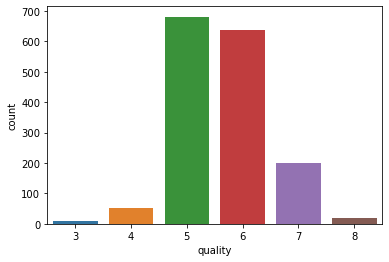

In [9]:
sns.countplot(x=df.quality);

In [10]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

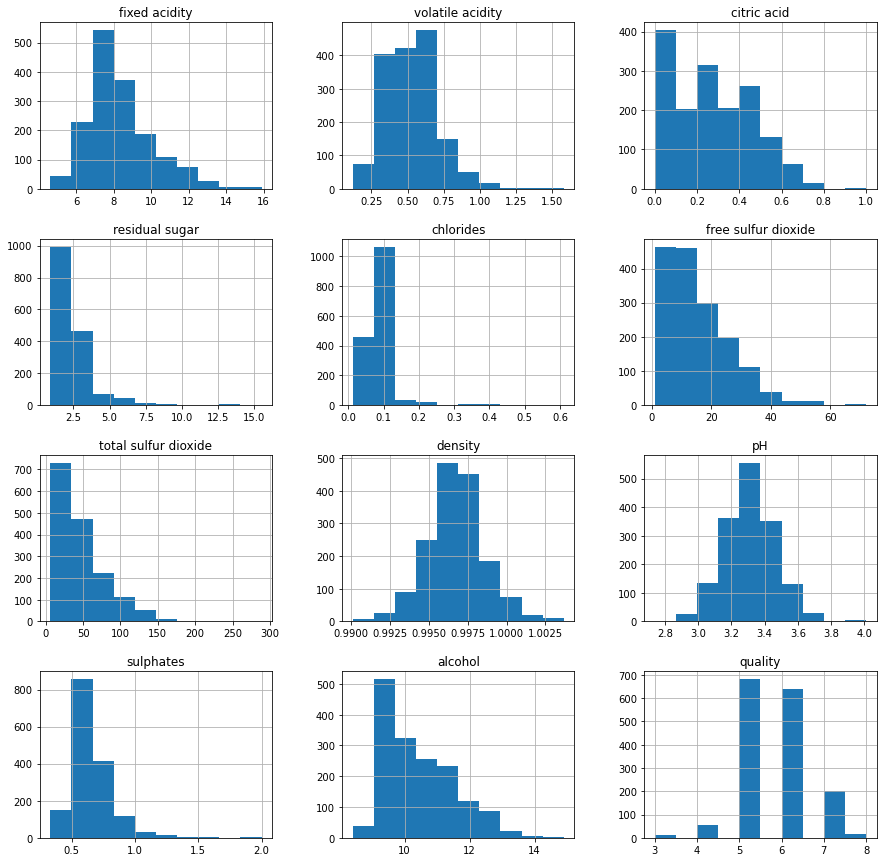

In [11]:
# Histogramy dla wszystkich zmiennych

df.hist(figsize=(15, 15));

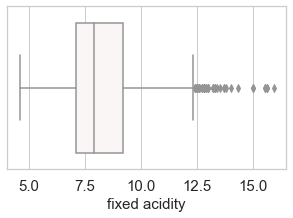

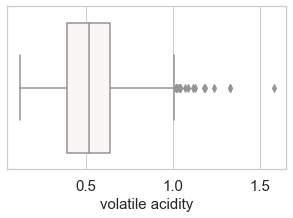

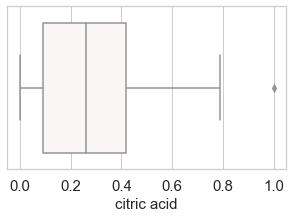

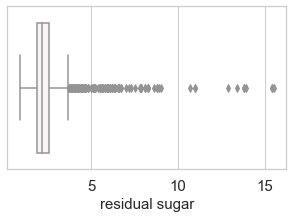

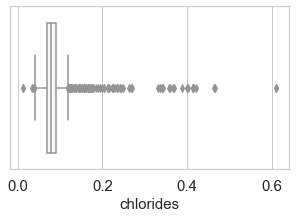

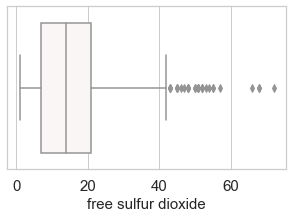

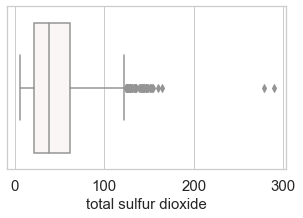

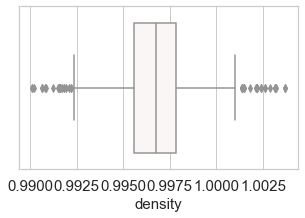

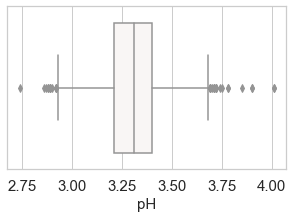

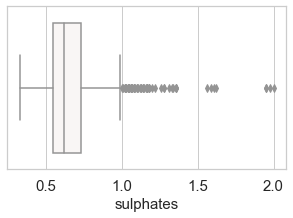

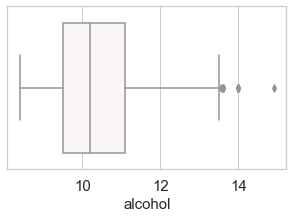

In [13]:
# Boxploty

sns.set_theme(style="whitegrid")

list_columns = list(df.drop("quality", axis=1).columns)

for column in list_columns:
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=df[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

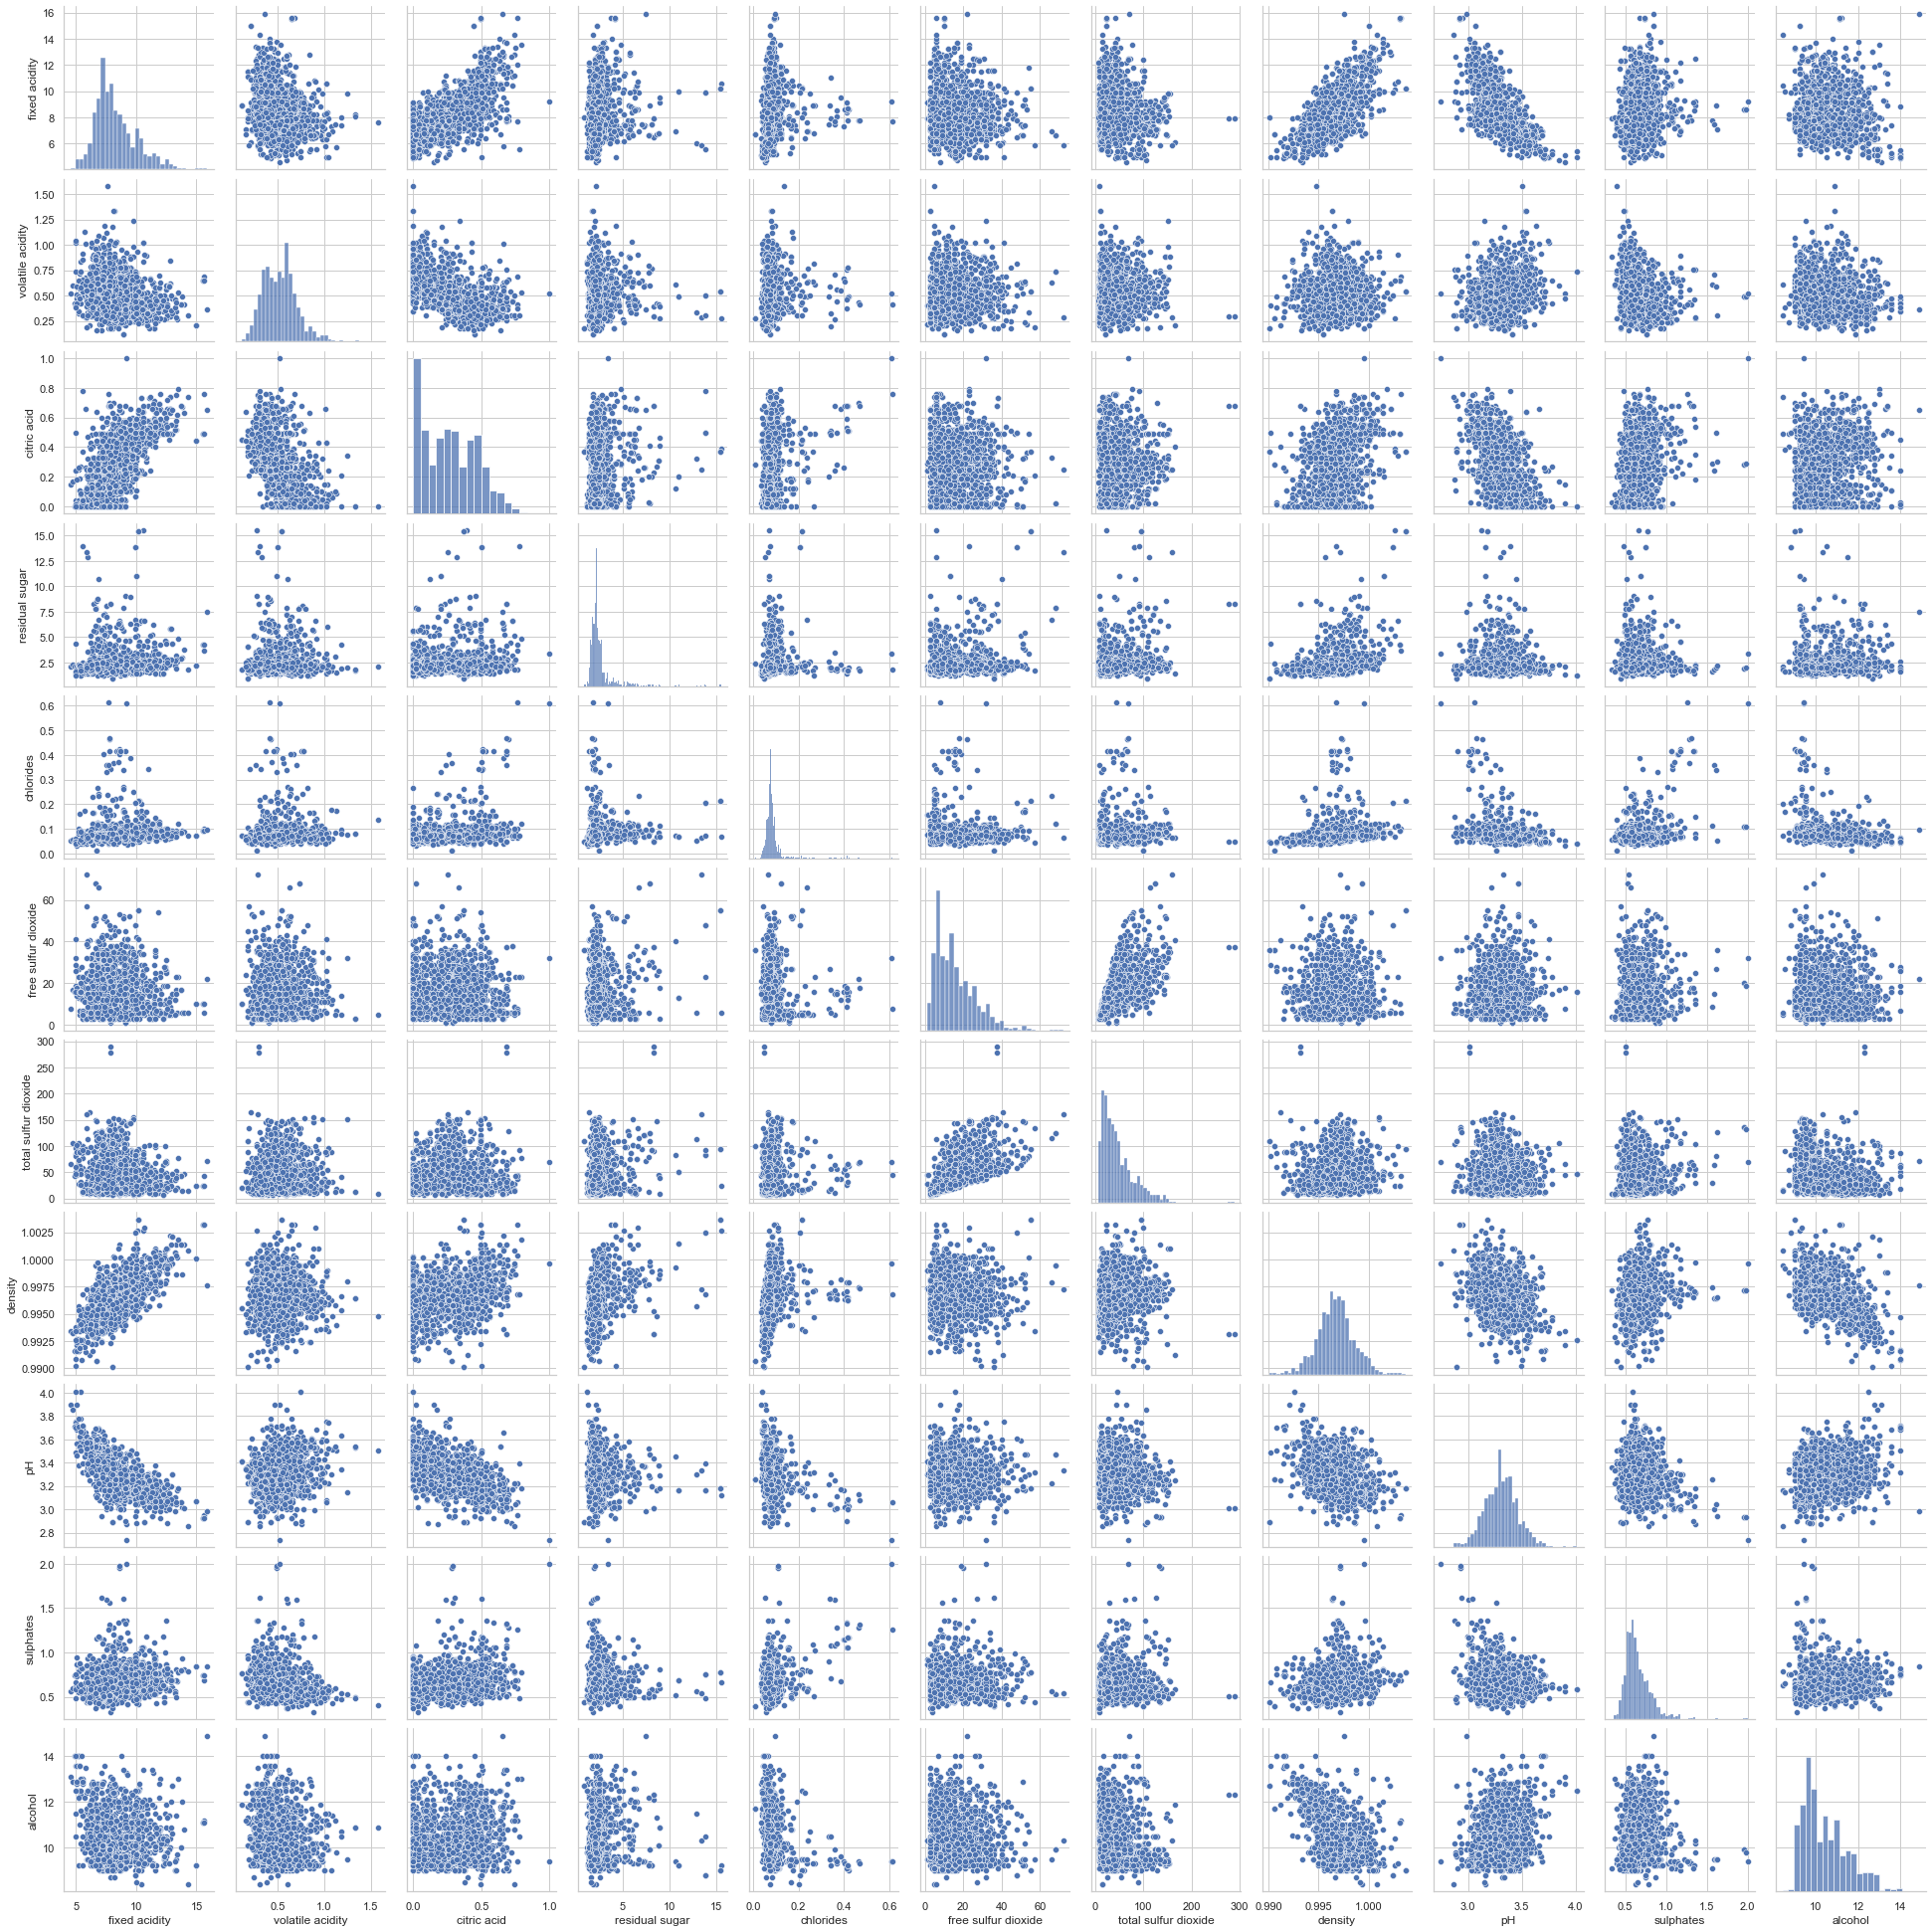

In [14]:
# Korelacje

sns.pairplot(df.drop("quality", axis=1));

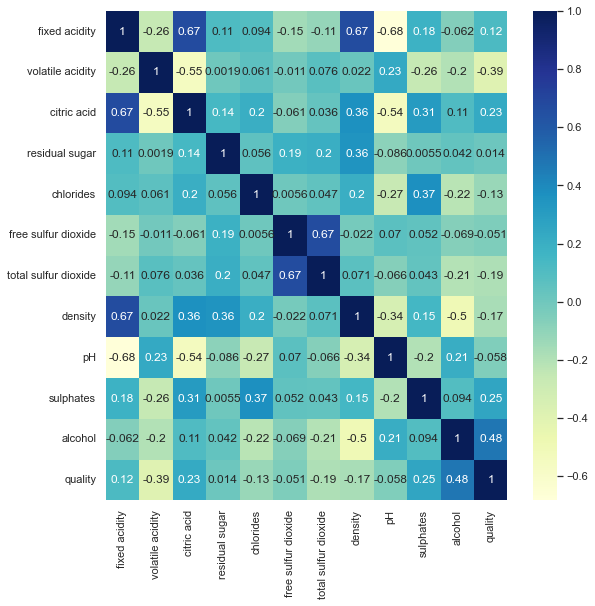

In [15]:
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df.corr(), cmap="YlGnBu", annot = True);

In [20]:
# Usuwanie outlier'ów (wartości większych niż 3 odchylenia standardowe) z zestawu danych (konieczne w przypadku KNN i PCA). 

z_scores = stats.zscore(df)

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_out = df[filtered_entries]

print("Liczba rekordów przed usunięciem outlier'ów: ", df.shape[0])
print("Liczba rekordów po usunięciu outlier'ów: ", df_out.shape[0])

Liczba rekordów przed usunięciem outlier'ów:  1599
Liczba rekordów po usunięciu outlier'ów:  1451


In [81]:
df_out.quality.value_counts()

5    617
6    586
7    185
4     47
8     16
Name: quality, dtype: int64

In [35]:
# Podział na zbiór treningowy i testowy

X = df_out.drop("quality", axis=1)
y = df_out.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = df_out.quality, random_state=0)

In [27]:
# Normalizacja zestawu treningowego do rozkładu normalnego, wyznaczenie wartości średnich i odchyleń standardowych
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)

print(scaler.mean_, scaler.scale_)

[ 8.31133005  0.52287685  0.26209852  2.37517241  0.08090542 15.03940887
 43.27783251  0.99669562  3.31796059  0.64143842 10.4337931 ] [1.68018874e+00 1.68581885e-01 1.90192617e-01 8.28057460e-01
 1.96758690e-02 9.20785827e+00 2.82680633e+01 1.68968782e-03
 1.42297400e-01 1.25151730e-01 1.00306853e+00]


In [28]:
# Normalizacja zestawu testowego do rozkładu normalnego z wykorzystaniem wartości średnich i odch. std z zestawu treningowego

X_test_std = scaler.transform(X_test)

In [49]:
# Model Random Forest

model_RF = RandomForestClassifier(random_state=1)

model_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [50]:
cross_val_score(model_RF, X_train, y_train, cv=10).mean()

0.6611920015530963

In [51]:
model_RF.score(X_test, y_test)

0.7178899082568807

In [68]:
param_grid = {
    "n_estimators": [170, 180, 190, 200],
    "criterion": ["entropy"],
    "max_depth": [20, 25, 30, 35, 40, 50, None],
    "max_features": ["sqrt", "log2", None],
    "class_weight": ["balanced"]
             }

grid_search = GridSearchCV(model_RF, param_grid=param_grid, cv=10, verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [20, 25, 30, 35, 40, 50, None],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [170, 180, 190, 200]})

In [69]:
print("Najlepsze parametry: ", grid_search.best_params_)
print("Najwyższy score: ", grid_search.best_score_)

Najlepsze parametry:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 180}
Najwyższy score:  0.6670743544942728


In [71]:
model_RF_best = RandomForestClassifier(random_state=1, **grid_search.best_params_)

model_RF_best.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, max_features='sqrt', n_estimators=180,
                       random_state=1)

In [72]:
model_RF_best.feature_importances_

array([0.06291165, 0.13086093, 0.09880334, 0.05668142, 0.08078097,
       0.05925823, 0.08499605, 0.07242675, 0.09245546, 0.13457652,
       0.12624868])

In [73]:
feature_importances = pd.DataFrame(model_RF_best.feature_importances_, index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
sulphates,0.134577
volatile acidity,0.130861
alcohol,0.126249
citric acid,0.098803
pH,0.092455
total sulfur dioxide,0.084996
chlorides,0.080781
density,0.072427
fixed acidity,0.062912
free sulfur dioxide,0.059258


In [75]:
y_pred_RF = model_RF_best.predict(X_test)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test, y_pred_RF))

print("Raport klasyfikacyjny: \n", classification_report(y_test, y_pred_RF, zero_division=1))

Confusion matrix - tablica pomyłek
 [[  0  11   3   0   0]
 [  0 157  28   0   0]
 [  0  47 124   5   0]
 [  0   2  17  37   0]
 [  0   0   2   3   0]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           4       1.00      0.00      0.00        14
           5       0.72      0.85      0.78       185
           6       0.71      0.70      0.71       176
           7       0.82      0.66      0.73        56
           8       1.00      0.00      0.00         5

    accuracy                           0.73       436
   macro avg       0.85      0.44      0.44       436
weighted avg       0.74      0.73      0.71       436



In [78]:
# Model KNN

model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train_std, y_train)

KNeighborsClassifier()

In [79]:
cross_val_score(model_KNN, X_train_std, y_train, cv=10).mean()

0.5625897883906038

In [80]:
model_KNN.score(X_test_std, y_test)

0.5940366972477065

In [82]:
y_pred_KNN = model_KNN.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test, y_pred_KNN))

print("Raport klasyfikacyjny: \n", classification_report(y_test, y_pred_KNN))

Confusion matrix - tablica pomyłek
 [[  0  10   4   0   0]
 [  2 145  37   1   0]
 [  1  71  90  13   1]
 [  0   6  26  24   0]
 [  0   1   2   2   0]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           4       0.00      0.00      0.00        14
           5       0.62      0.78      0.69       185
           6       0.57      0.51      0.54       176
           7       0.60      0.43      0.50        56
           8       0.00      0.00      0.00         5

    accuracy                           0.59       436
   macro avg       0.36      0.34      0.35       436
weighted avg       0.57      0.59      0.58       436



In [88]:
# Dobór optymalnych parametrów dla modelu (ten etap jest powtarzany kilka razy żeby dobrać najlepsze zakresy)

param_grid_KNN = {
            "n_neighbors": list(range(10,30)),
            "weights": ["uniform", "distance"],
            "metric": ["minkowski"],
            "p": [1, 2, 3, 4],
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
             }

grid_KNN = GridSearchCV(model_KNN, param_grid=param_grid_KNN, cv=10, verbose=0, n_jobs=-1)
grid_KNN.fit(X_train_std, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['minkowski'],
                         'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28,
                                         29],
                         'p': [1, 2, 3, 4],
                         'weights': ['uniform', 'distance']})

In [89]:
print("Najlepsze parametry: ", grid_KNN.best_params_)
print("Najwyższy score: ", grid_KNN.best_score_)

Najlepsze parametry:  {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 19, 'p': 3, 'weights': 'distance'}
Najwyższy score:  0.6659774801009513


In [90]:
# Zastosowanie najlepszych parametrów dla modelu

model_KNN_best = KNeighborsClassifier(**grid_KNN.best_params_)

model_KNN_best.fit(X_train_std, y_train)

KNeighborsClassifier(n_neighbors=19, p=3, weights='distance')

In [91]:
model_KNN_best.score(X_test_std, y_test)

0.7155963302752294

In [93]:
y_pred_KNN2 = model_KNN_best.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test, y_pred_KNN2))

print("Raport klasyfikacyjny: \n", classification_report(y_test, y_pred_KNN2, zero_division=1))

Confusion matrix - tablica pomyłek
 [[  0  11   2   1   0]
 [  0 153  32   0   0]
 [  0  50 121   5   0]
 [  0   1  17  38   0]
 [  0   0   2   3   0]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           4       1.00      0.00      0.00        14
           5       0.71      0.83      0.77       185
           6       0.70      0.69      0.69       176
           7       0.81      0.68      0.74        56
           8       1.00      0.00      0.00         5

    accuracy                           0.72       436
   macro avg       0.84      0.44      0.44       436
weighted avg       0.73      0.72      0.70       436

